# Advanced Lane Lines
#### Detection of Lane Lines using Advanced CV Techniques
In this project we will be using advanced techniques for finding lane lines compared with the first project.  Techniques used will include edge detection, image thresholding, perspective transforms and fitting polynomials for finding and detecting lane lines in camera images.

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [2]:
# Helpful plotting function
def plot(images, no_rows, no_cols, width = 10., height = 4., color='gray'):
    fig = plt.figure(1, (width, height))
    i = 0
    
    for image in images:
        sub = fig.add_subplot(no_rows, no_cols, i + 1)
        sub.imshow(image, color)
        sub.axis("off")
        i += 1

    plt.show()

### Camera Calibration
Prior to detecting lane lines we need to first calibrate the camera to account for lense distortion common in all modern day cameras.  Once we have a calibrated camera image, we can then accurately use perspective transformation for computing line curvature.

In [3]:
# Set chessboard corner sizes
nb_cornerx = 9
nb_cornery = 6
# Set calibration image path
calibration_path = "./camera_cal/"

#### Define the functions used to calibrate the camera
Utilising the findChessboardCorners in OpenCV we can compute distortion coefficients to calibrate the camera and undistort any images affected by camera lense distortion.

In [4]:
# Define a Camera class with methods for calibration
# and undistorting images
class Camera():
    
    Matrix = None
    Distortion = None
    ImageSize = None
    
    def __init__(self, mtx = None, dist = None):
        self.Matrix = mtx
        self.Distortion = dist
    
    # Define corner detection
    def find_corners(self, img, dimensions):
        # Define translation and distortion parameters
        objpoints = []
        imgpoints = []

        # Initialise chessboard point space parameter
        objp = np.zeros((dimensions[1] * dimensions[0], 3), np.float32)
        objp[:,:2] = np.mgrid[0:dimensions[0], 0:dimensions[1]].T.reshape(-1, 2) # x,y coordinates

        # convert to grayscale for detection
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # find corners usng grayscale image
        [ret, corners] = cv2.findChessboardCorners(gray, dimensions, None)

        return [ret, objp, corners]
    
    # Camera calibration function
    def calibrate(self, images, dimensions):
        # Define real-world and image space coordinate arrays
        objpoints = []
        imgpoints = []

        self.ImageSize = (images[0].shape[1], images[0].shape[0])

        for img in images:
            # detect corners in the chessboard calibration image
            [ret, points, corners] = self.find_corners(img, dimensions)

            if (ret == True):
                # add the real-world points along with image space points to the arrays
                objpoints.append(points)
                imgpoints.append(corners)
        
        # calibrate camera using point spaces
        [ret, mtx, dist, rvecs, tvecs] = cv2.calibrateCamera(objpoints, imgpoints, self.ImageSize, None, None)    
        
        # store calibration
        self.Matrix = mtx
        self.Distortion = dist
        
        return [self.Matrix, self.Distortion]
    
    ### Define the warping functions ###
    def transform(self, src, dst):
        if (src is not None and dst is not None):
            self.M = cv2.getPerspectiveTransform(src, dst)
        if (src is not None and dst is not None):
            self.Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp an image using the specified source and destination coordinate mappings.
    def warp(self, img):
        return cv2.warpPerspective(img, self.M, self.ImageSize, flags=cv2.INTER_LINEAR)

    # Unwarps an image using the specified source and destination coordinate mappings.
    def unwarp(self, img):
        return cv2.warpPerspective(img, self.Minv, self.ImageSize, flags=cv2.INTER_LINEAR)
    
    # Image undistortion using translation coefficients
    def undistort(self, img):
        return cv2.undistort(img, self.Matrix, self.Distortion, None, self.Matrix)

*Create a camera reference for the scope of the project*

In [5]:
### Camera Reference ###
camera = Camera()

__Plot the calibration images with detected chessboard lines__

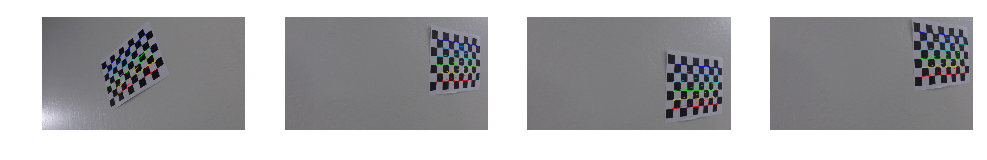

In [6]:
import os

# fill calibration images
calibration_images = [mpimg.imread(os.path.join(calibration_path, x)) for x in os.listdir(calibration_path)]

chessboard_images = []
for img in calibration_images:
    [ret, objpoints, corners] = camera.find_corners(img, (nb_cornerx, nb_cornery))
    # if corners found, draw them on the image
    if (ret == True):
        img = cv2.drawChessboardCorners(img, (nb_cornerx, nb_cornery), corners, ret)
        chessboard_images.append(img)

# plot the images after corner detection and drawing lines
plot(chessboard_images[3:7], 1, 4, 12., 4.)

__Show a single calibration image, before and after distortion correction__

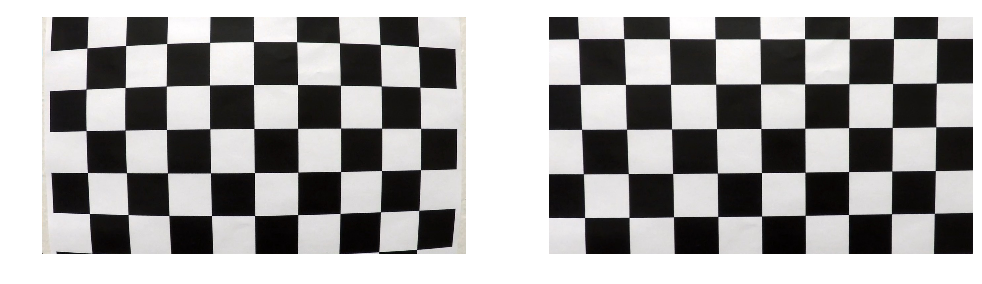

In [7]:
### Camera Calibration ###
# calibrate the camera using the calibration chessboard images and dimensions
[camera_mtx, camera_dist] = camera.calibrate(calibration_images, (nb_cornerx, nb_cornery))
# show the result
plot([calibration_images[0], camera.undistort(calibration_images[0])], 1, 2, 12., 4.)

__Show a road scene image before and after applying distortion correction.__

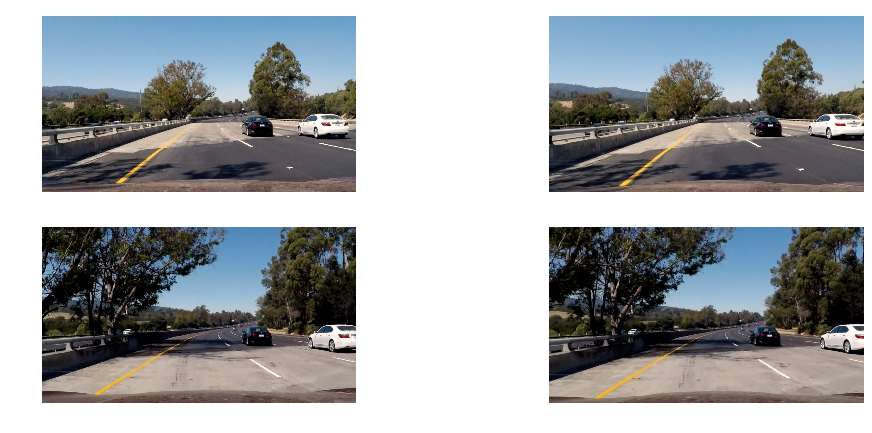

In [8]:
# Define sample road scene test images
test1 = "./test_images/test4.jpg"
test2 = "./test_images/test5.jpg"
# undistort each
undistorted_examples = [mpimg.imread(test1), camera.undistort(mpimg.imread(test1)), \
                        mpimg.imread(test2), camera.undistort(mpimg.imread(test2))]
# plot each side by side with undistorted versions
plot(undistorted_examples, 2, 2, 12., 5.)

*As per the images above, you can see that the right column of images, after distortion correction, appear more clipped on both sides of the images.*

### Lane Detection
*Detecting lane line regions using colour maps, thresholds and gradients*

**Create the pipeline used for producing a binary image as a result of applying colour thresholding, gradients and other techniques for extracting possible lane line pixels** 

In [9]:
### Lane Line helper functions ###

# Masks using colour thresholding
# - thresholds: 2D array of threshold values for each colour channel
def mask_thresholds(img, thresholds = [(220,255), (0,255), (0,90)], mask = 1):
    # init empty binary image map
    binary_result = np.zeros((img.shape[0], img.shape[1]))
    # apply thresholds for each channel
    for t in range(len(thresholds)):
        channel = img[:,:,t]
        binary_result[((binary_result == mask) \
                       | ((channel >= thresholds[t][0]) & (channel <= thresholds[t][1])))] = mask
    
    return binary_result

# Computes the raw sobel values for each direction (x and y) for a given image
# - img: Input image in RGB format
# - kernel: Scalar value >= 3, for the kernel size
def compute_sobel(img, kernel):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # compute sobel derivatives
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    
    return [sobelx, sobely]

# Computes the sobel threshold binary map for a given image
# - img: Input image in RGB format
# - kernel: Scalar value >= 3, for the kernel size
# - thresh_x: 2D Tuple of threshold values for the x coordinate
# - thresh_y: 2D Tuple of threshold values for the y coordinate
def sobel_threshold(img, kernel = 3, thresh_x = (20, 100), thresh_y = (0, 255), mask = 1):
    # compute sobel
    [sobelx, sobely] = compute_sobel(img, kernel)
    
    # take the max values
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # scale to 0-255 range
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    # apply threshold values
    binary_output = np.zeros_like(abs_sobelx)
    if (thresh_x is not None):
        binary_output[((scaled_sobelx >= thresh_x[0]) & (scaled_sobelx <= thresh_x[1]))] = mask
    
    if (thresh_y is not None and thresh_x is not None):
        binary_output[(((scaled_sobely >= thresh_y[0]) & (scaled_sobely <= thresh_y[1]))\
                      & (binary_output == mask))] = mask
    elif (thresh_y is not None):
        binary_output[((scaled_sobely >= thresh_y[0]) & (scaled_sobely <= thresh_y[1]))] = mask
    
    return binary_output

# Computes the sobel magnitude binary map for a given image
# - img: Input image in RGB format
# - kernel: Scalar value >= 3, for the kernel size
# - thresh: 2D Tuple of threshold values
def sobel_magnitude(img, kernel = 3., thresh = (20, 100), mask = 1):
    # compute sobel
    [sobelx, sobely] = compute_sobel(img, kernel)
    
    # take the max values
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # compute the magnitude
    mag_sobel = np.sqrt(abs_sobelx**2. + abs_sobely**2.)
    # scale within 0-255 range
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # apply threshold values
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = mask
    
    return binary_output

# Computes the sobel direction gradient for a given image
# - img: Input image in RGB format
# - kernel: Scalar value >= 3, for the kernel size
# - thresh: 2D Tuple of threshold values
def sobel_direction(img, kernel=3, thresh = (0, np.pi/2), mask = 1):
    # compute sobel
    [sobelx, sobely] = compute_sobel(img, kernel)
    # take the max values
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # compute directional gradients
    grad = np.arctan2(abs_sobely, abs_sobelx)
    # create mask
    binary_output = np.zeros_like(grad)
    binary_output[(grad >= thresh[0]) & (grad <= thresh[1])] = mask
    
    return binary_output

**Combine all the helper CV functions into one function which returns a binary mask of the possible lane lines found within an image.**

In [10]:
### Lane Line Detection Pipeline ###

# Applies a combination of CV techniques to an input image for masking lane lines 
# in an image.
# - img: Input image in RGB format
# - kernels: 3D tuple of kernel values for computing absolute, magnitude and directional sobel coordinates
# - abs_thresh: 2D tuple of min and max threshold values for the absolute Sobel value mask
# - grad_thresh: 2D tuple of min and max threshold values for the magnitude Sobel value mask
# - dir_thresh: 2D tuple of min and max threshold values for the directional Sobel value mask
# Returns: Binary mask where the mask value is a likely candidate lane line.
def lane_line_mask(img, kernels, abs_thresh, mag_thresh, dir_thresh, mask = 1):
    # compute sobel threshold, magnitude and directional gradients
    sobel_abs = sobel_threshold(img, kernel=kernels[0], thresh_x=abs_thresh[0], thresh_y=abs_thresh[1], mask=mask)
    sobel_mag = sobel_magnitude(img, kernel=kernels[1], thresh=mag_thresh, mask=mask)
    sobel_dir = sobel_direction(img, kernel=kernels[2], thresh=dir_thresh, mask=mask)
    # combine the sobel masks
    combined = np.zeros_like(sobel_dir)
    combined[((sobel_abs == mask) | ((sobel_mag == mask) & (sobel_dir == mask)))] = mask
    # convert to YUV colour space
    yuv_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    # threshold the Y,U,V colour channels (ignore U channel)
    yuv_mask = mask_thresholds(yuv_img, [(220,255), (0,0), (0,90)], mask)
    # combine the detected lines from sobel and colour thresholding
    result = np.zeros_like(combined)
    result[((combined == mask) | (yuv_mask == mask))] = mask
    
    return result

In [11]:
# define test image path
test_path = "./test_images/"

__Show example masked images as a result of applying combined CV techniques like thresholding and masking for the purposes of finding lane lines in the input image__

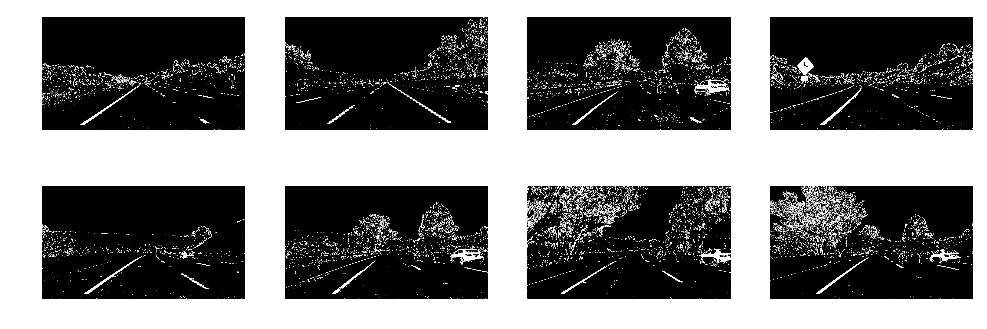

In [12]:
# Show example binary masking of test images

# Init masking parameters
mask = 255

sobel_abs_thresh = [(20, 100), None] # absolute [x,y]
sobel_mag_thresh = (30, 100) # 8, 110 # magnitude
sobel_dir_thresh = (0.7, np.pi/2.) # direction

sobel_kernels = (3, 9, 9) # absolute / magnitude / direction
# Init test examples
line_extraction_examples = [mpimg.imread(os.path.join(test_path, x)) for x in os.listdir(test_path)]
# Images array of computed masks
line_extracted_examples = []

for example in line_extraction_examples:
    mask_img = lane_line_mask(example, sobel_kernels, sobel_abs_thresh, sobel_mag_thresh, sobel_dir_thresh, mask)
    line_extracted_examples.append(mask_img)

plot(line_extracted_examples, 2, 4, 12., 4.)

*We can see that in most cases it is quite evident where the lane line pixels lie.  We also have a number of features such as neighbouring lane lines and road edges, which will be useful later on...*

### Lane Line Finding Pipeline
*Defines a pipeline for computing the lane lines, as detected Line objects, in each frame.  This is done by first computing the mask, then applying a perspective transform and using a sliding window to find the most likely candidate pixels of a lane.  The resulting pixel candidates are then processed using a polynomial function with the result drawn over the input image and the perspective returned to the appropriate view.*

In [13]:
# Prepare perspective transforms
img_size = camera.ImageSize
p_offset = 30
y_center = 440
y_margin = 50
x_margin = 320

# Define our warp source and destination coordinates
src_map = np.float32([[(img_size[0]/2.)+p_offset, y_center],  # top-right
                      [img_size[0]-(x_margin-p_offset)*1, img_size[1]-y_margin*2.],  # bottom-right
                      [(x_margin-p_offset)*1, img_size[1]-y_margin*2.],  # bottom-left
                      [(img_size[0]/2.)-p_offset, y_center]]) # top-left 

dst_map = np.float32([[img_size[0]-(x_margin+p_offset), 0],    # top-right
                      [img_size[0]-x_margin, img_size[1]],  # bottom-right
                      [x_margin, img_size[1]],  # bottom-left
                      [x_margin+p_offset, 0]])   # top-left

# initialise camera perspective transforms
camera.transform(src_map, dst_map)

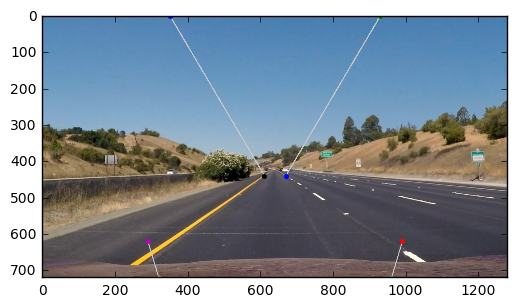

In [14]:
# plot the coordinates on an example
test_img = line_extraction_examples[0]
point_img = np.copy(test_img)

randcolor = lambda x, y: (np.random.randint(x, y), np.random.randint(x, y), np.random.randint(x, y))

for p1, p2 in zip(src_map, dst_map):
    cv2.line(point_img, (p1[0], p1[1]), (p2[0], p2[1]), (200,200,200), 2)
    plt.plot(p1[0], p1[1], ".")
    plt.plot(p2[0], p2[1], ".")
    
plt.imshow(point_img)
plt.show()

#### Perspective Transform
*Apply perspective transformation to each image for the purpose of applying signal processing to detect the lane lines.*

__Perspective warped examples using the camera warp function__

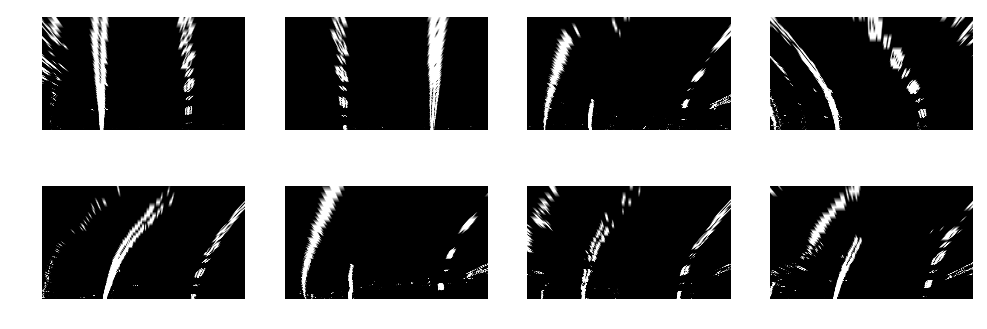

In [15]:
warped_examples = []
for example in line_extracted_examples:
    warped = camera.warp(example)
    warped_examples.append(warped)
plot(warped_examples, 2, 4, 12., 4.)

*As per the images above, there appears to be another lane signal appearing. This additional signal is the road edge which provides further cues as to the positions of the lane lines as well as lane curvature.*

#### Signal Processing the Lane Lines
Use signal processing to find the best candidate lane line pixels using a sliding window function over the likely candidate pixels.

**Define the lane signal processing pipeline here.**

In [16]:
# Import useful libraries
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [17]:
# Lane fitting function

# Normalises the input to the value of 0-1.
# - Returns: array of size X
def normalise(X):
    return X / np.sum(X, axis=0)

# Finds the nearest element to the specified value
# - Returns: index of nearest element
def find_nearest(array, value):
    return np.argmin(np.abs(array - value))

# Returns the max value of a given signal
# - Returns: Tuple of max index and corresponding value
def compute_signal(signal, min_range, max_range, offset, threshold):
    # normalise ranges
    min_range_i = max(min(min_range, max_range), 0)
    max_range_i = min(max(max_range, min_range), len(signal))
    
    if (max_range_i - min_range_i <= 0):
        max_range_i = min(max_range_i + offset, len(signal))
    
    centerv = np.argmax(signal[min_range_i : max_range_i]) + min_range_i - offset
    maxv = signal[centerv + offset]
    
    if (maxv <= threshold):
        centerv = np.median([min_range_i, max_range_i]) - offset
        maxv = signal[int(centerv)]
        
    return [centerv, maxv]

# Fits valid lane pixel windows which correlate to prospective lane lines in an image.
# - image: Input image (single channel)
# - window_width: Width of the sliding window
# - window_height: Height of the sliding window
# - margin: Sliding window margin
# - threshold: Value threshold for max convolution
# - zoom: Zoom height margin for computing the greater window signal
# - gain: memory weight for lane heading
# - scan: memory length for ranging lane distance values
# - memory: number of timesteps for computing lane heading
# - theta: degrees of freedom of the lane heading
# - gamma: thresholding value to keep discount factors within limits
# - eps: epsilon parameter to avoid divide by zero errors
def find_window_centroids(img, window_width, window_height, margin, threshold = 0.2, zoom = 2, \
                          gain = 0.8, scan = 3, memory = 7, theta = 2, gamma = 1.5, eps = 1e-08):
    # Create our window template that we will use for convolutions
    window = np.ones(window_width) 
    
    height = img.shape[0]
    width = img.shape[1]
    
    # Use window_width/2 as offset because convolution signal reference is 
    # at right side of window, not center of window
    offset = int(window_width * 0.5)
    
    # Convolved signal of the lower vertical region
    hist = np.sum(img[int(height * 0.8) :, :], axis=0)
    window_signal = normalise(np.convolve(window, hist))
    
    # Find Left lane signal
    [l_center, l_max] = compute_signal(window_signal, 0, int(width/2), offset, threshold)
    l_dist = l_pred_center = 0
    l_center_prev = l_center
    
    # Find Right lane signal
    [r_center, r_max] = compute_signal(window_signal, int(width/2), len(window_signal), offset, threshold)
    r_dist = r_pred_center = 0
    r_center_prev = r_center
    
    # Initialise moving average memory and add what we found for the first layer
    window_memory = np.empty((0,8)) # levels x [l_center, l_dist, l_max, l_disc, r_center, r_dist, r_disc, r_max]
    window_memory = np.vstack((window_memory, [l_center, l_dist, l_center, l_max, \
                                               r_center, r_dist, r_center, r_max]))
    
    l_max_prev = l_max
    r_max_prev = r_max
    
    # Go through each layer looking for max pixel locations
    for level in range(1, (int)(height / window_height)):
        # convolve the window into the vertical slice of the image
        min_range = int(height - (level + 1) * window_height)
        max_range = int(height - (level) * window_height)
        # Compute the convolved signal from the current window
        image_layer = np.sum(img[min_range : max_range, :], axis=0)
        window_signal = normalise(np.convolve(window, image_layer))
        
        # Find the zoom range window
        min_zoom_range = int(max(height - (level + zoom) * window_height, 0))
        max_zoom_range = int(min(height - max((level - zoom), 0) * window_height, height))
        # Compute the convolved signal from the current zoom level
        region_layer = np.sum(img[min_zoom_range : max_zoom_range, :], axis=0)
        zoom_signal = normalise(np.convolve(window, region_layer))
        
        if (level > 1):
        # Find the best left centroid by using past left center as a reference
            y_vals = np.arange(level - memory, level)[-len(window_memory[-memory:]):]
            # find left heading
            l_params = np.polyfit(y_vals, window_memory[-memory:,0], theta)
            l_pred_center = np.polyval(l_params, level)
            # find right heading
            r_params = np.polyfit(y_vals, window_memory[-memory:,4], theta)
            r_pred_center = np.polyval(r_params, level)
        else:
            l_pred_center = l_center_prev + l_dist
            r_pred_center = r_center_prev + r_dist
        
        # Upper and lower bounded discount factors
        l_pred_center = int(max(l_pred_center, 0))
        r_pred_center = int(min(r_pred_center, width))
        
        ### LEFT ###
        # Compute window and zoom signals for left
        l_min_index = int(max(l_pred_center + offset - margin, 0))
        l_max_index = int(min(l_pred_center + offset + margin, r_center_prev - offset))
        # Compute the left window signal
        [l_center, l_max] = compute_signal(window_signal, l_min_index, l_max_index, offset, threshold)
        # Compute the left zoom region signal
        [lz_center, lz_max] = compute_signal(zoom_signal, l_min_index, l_max_index, offset, threshold)
        # Smooth left detectors
        l_weights = np.array([l_max, lz_max * (1./zoom)]) + eps
        l_center = np.average([l_center, lz_center], weights = l_weights)
        l_max_new = l_weights.mean()
        
        ### RIGHT ###
        # Compute window and zoom signals for right
        r_min_index = int(max(r_pred_center + offset - margin, l_center_prev + offset))
        r_max_index = int(min(r_pred_center + offset + margin, width))
        # Compute the right window signal
        [r_center, r_max] = compute_signal(window_signal, r_min_index, r_max_index, offset, threshold)
        # Compute the right zoom region signal
        [rz_center, rz_max] = compute_signal(zoom_signal, r_min_index, r_max_index, offset, threshold)
        # Smooth right detectors
        r_weights = np.array([r_max, rz_max * (1./zoom)]) + eps
        r_center = np.average([r_center, rz_center], weights = r_weights)
        r_max_new = r_weights.mean()
        
        # Averaged bilateral shift to avoid lane errors
        mean_dist = np.average(window_memory[0:scan:,4] - window_memory[0:scan:,0])
        if (l_max > r_max):
            r_center = np.average([l_center, l_center_prev + l_dist], \
                                  weights = [gain, 1.0-gain]) + mean_dist
        else:
            l_center = np.average([r_center, r_center_prev + r_dist], \
                                  weights = [gain, 1.0-gain]) - mean_dist
        
        # Remember lane headings
        l_dist = l_center - l_center_prev
        r_dist = r_center - r_center_prev
        
        # Update max t-1
        l_max_prev = l_max
        r_max_prev = r_max
        l_center_prev = l_center
        r_center_prev = r_center
        # Add what we found for that layer
        window_memory = np.vstack((window_memory, [l_center, l_dist, l_pred_center, l_max_new, \
                                                   r_center, r_dist, r_pred_center, r_max_new]))
    
    return window_memory

# Smoothes a path by gradient descent
# path: a 2D array of path points
def smooth_path(path, beta = 0.5, alpha = 0.1, tolerance = 1e-08, max_iter = 1000):
    # Make a deep copy of path
    output = np.copy(path)
    # set diff to tolerance
    diff = tolerance
    count = 0
    while (diff >= tolerance and count <= max_iter):
        # reset difference
        diff = 0
        count += 1
        for i in range(1, len(path)-1):
            for j in range(len(path[i])):
                aux = output[i][j]
                # compute gradients
                path_diff = (path[i][j] - output[i][j])
                path_err = (output[i-1][j] + output[i+1][j] - 2.0 * output[i][j])
                output[i][j] += (beta * path_diff) + (alpha * path_err)
                # accumulate loss
                diff += abs(aux - output[i][j])
    # return smoothed path
    return output

### Window Drawing functions ###

# Applies a window mask on the current image, centroid pair at the specified level
# Returns: mask of the current sliding window
def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    if not np.isnan(center):
        output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),\
               max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

# Draws the centroids returned by find_window_centroids
# Returns: a new image with each window overlayed on the original image
def draw_window_centroids(img, centroids, window_width, window_height, color='red'):
    # If we found any window centers
    if len(centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(img)
        r_points = np.zeros_like(img)

        # Go through each level and draw the windows 	
        for level in range(0,len(centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width, window_height, img, centroids[level][0], level)
            r_mask = window_mask(window_width, window_height, img, centroids[level][1], level)
            # Add graphic points from window mask here to total pixels found
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points + l_points, np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        if (color=='red'):
            template = np.array(cv2.merge((template, zero_channel, zero_channel)), np.uint8)
        else:
            template = np.array(cv2.merge((zero_channel, template, zero_channel)), np.uint8)
        warpage = np.array(cv2.merge((img, img, img)), np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((img, img, img)),np.uint8)
    
    return output

#### Process Lanes and Smooth Paths
Apply the signal processing function and then smooth the paths returned by the function.

**Apply the sliding window on the perspective warped examples and show the result.**

C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:

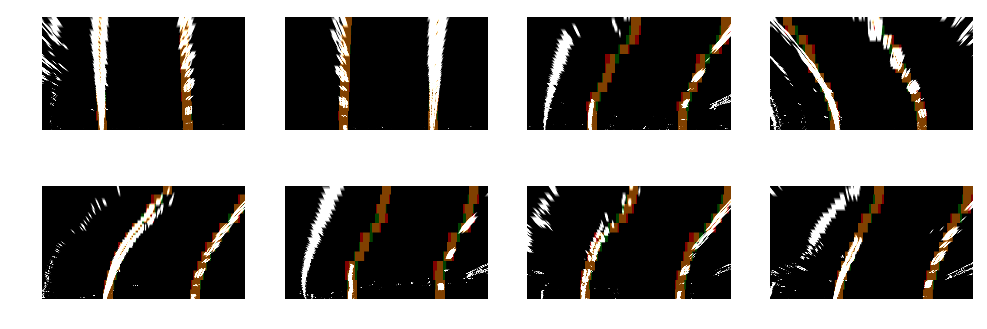

In [18]:
### Sliding Window settings ###
window_width = 60 # sliding window width
window_height = 60 # sliding window height
window_margin = 80 # sliding window margin

window_examples = []
for example in warped_examples:
    centroids = find_window_centroids(example, window_width, window_height, window_margin, threshold = 0.0001, gain = 0.9)
    centroids_smooth = smooth_path(centroids[:,[0,4]], beta=0.5, alpha = 0.5)
    # process each centroid
    centroid_res = draw_window_centroids(example, centroids[:,[0,4]], window_width, window_height)
    smooth_res = draw_window_centroids(example, centroids_smooth, window_width, window_height, 'green')
    
    result = cv2.addWeighted(centroid_res, 1, smooth_res, 0.5, 0.0)
    window_examples.append(result)
# plot the results
plot(window_examples, 2, 4, 12., 4.)

In [19]:
# Returns the x,y pairs of nonzero pixels
def get_nonzero(img, slide = 2):
    pairs = np.empty((0, 2))
    for x in range(img.shape[1]):
        if (x % slide == 0):
            for y in range(img.shape[0]):
                if (y % slide == 0 and img[y, x] > 0):
                        pairs = np.vstack((pairs, [x, y]))
    return pairs

# Counts the number of lane lines visible within an image
# WARNING: Uses high cpu resources
# Returns: scalar
def count_lane_lines(img, max_lanes = 4):
    X = get_nonzero(img, slide = 4)
    Xk = np.dot(X, X.T) # compute kernel
    scores = []
    for clusters in range(2, max_lanes):
        kmeans = KMeans(n_clusters=clusters).fit(Xk)
        label = kmeans.labels_
        sc = silhouette_score(Xk, label, metric='euclidean')
        scores.append(sc)
    return np.argmax(scores)

In [20]:
### Line Finding Pipeline ###
class Tracker():
    
    # Initialises
    # - window_width: sliding window width
    # - window_height: sliding window height
    # - window_margin: sliding window margin
    # - smooth_factor: timesteps for averaging lane lines
    # - theta: polynomial term for regression functions
    # - threshold: value for thresholding the maximal in coordinate descent
    # - gain: gain value to keep lanes adjacent when tracking
    # - alpha: first smoothing value for minimising path errors
    # - beta: second smoothing value for minimising path errors
    def __init__(self, window_width, window_height, window_margin, smooth_factor = 3, \
                 theta = 2, threshold = 0.0001, gain = 0.9, alpha = 0.5, beta = 0.5, \
                 my_per_pix = 30 / 720, mx_per_pix = 3.7 / 700):
        self.window_width = window_width
        self.window_height = window_height
        self.window_margin = window_margin
        self.smooth_factor = smooth_factor
        self.theta = theta
        self.threshold = threshold
        self.gain = gain
        self.alpha = alpha
        self.beta = beta
        
        self.MY_per_pix = my_per_pix
        self.MX_per_pix = mx_per_pix
        
        self.left_lane = None
        self.right_lane = None
        
        # used for keeping track of smoothed lines
        self.counter = 0
    
    # Finds and detects the adjacent left and right lane lines in the given image scene.
    # - img: Raw input image in RGB colourspace.
    # Returns: 2D Tuple of left and right lane line objects (see Line class).
    def detect_lanes(self, img):
        # mask the input image
        mask = lane_line_mask(img, sobel_kernels, sobel_abs_thresh, sobel_mag_thresh, sobel_dir_thresh)
        # perspective transform
        pers_mask = camera.warp(mask)
        # compute the window centroids
        centroids = find_window_centroids(pers_mask, self.window_width, self.window_height, self.window_margin, \
                                          threshold = self.threshold, gain = self.gain, theta = self.theta)
        # smoothed centroids
        centroids_smooth = smooth_path(centroids[:,[0,4]], beta = self.beta, alpha = self.alpha)
        # construct y range
        y_vals = np.arange(0, mask.shape[0])
        y_vals_res = np.arange(mask.shape[0]-(self.window_height/2), 0, -self.window_height)
        # compute left line coefficients
        left_coef = np.polyfit(y_vals_res, centroids_smooth[:,0], self.theta)
        left_fit = left_coef[0] * y_vals * y_vals + left_coef[1] * y_vals + left_coef[2]
        left_fit = np.array(left_fit, np.int32)
        
        # compute right line coefficients
        right_coef = np.polyfit(y_vals_res, centroids_smooth[:,1], self.theta)
        right_fit = right_coef[0] * y_vals * y_vals + right_coef[1] * y_vals + right_coef[2]
        right_fit = np.array(right_fit, np.int32)
        # window offset
        offset_width = window_width / 2
        
        # construct left and right Line objects
        left = Line(left_coef, left_fit, y_vals, offset_width)
        right = Line(right_coef, right_fit, y_vals, offset_width)
        
        return (left, right)
    
    # Tracks and smoothes the lane lines detected from the previous detection
    # - left: Line object
    # - right: Line object
    def track(self, left, right):
        if (self.counter == 0):
            self.left_lane = left
            self.right_lane = right
        else:
            # average the lanes for n
            self.left_lane.smooth(left, self.smooth_factor)
            self.right_lane.smooth(right, self.smooth_factor)
        
        # increment counter for averaging
        self.counter += 1
    
    # Resets the tracking state and clears any lane memory
    def reset(self):
        self.counter = 0
    
    def draw_lanes(self, img, left, right):
        # initialise lane drawing layers
        road_img = np.zeros_like(img)
        road_imgbg = np.zeros_like(img)
        
        l_fit = left.fit()
        r_fit = right.fit()
        
        # fill polygons
        cv2.fillPoly(road_img, [l_fit], color = [0,0,255])
        cv2.fillPoly(road_img, [r_fit], color = [255,0,0])
        cv2.fillPoly(road_imgbg, [l_fit], color = [255,255,255])
        cv2.fillPoly(road_imgbg, [r_fit], color = [255,255,255])
        
        return (road_img, road_imgbg)
        
# Define a class to receive the characteristics of each line detection
class Line():
    # Initialises
    #  - coefficients: 1D array of polynomial coefficients
    #  - xvals: X points of the fitted polynomial
    #  - yvals: Y points of the fitted polynomial
    def __init__(self, coefficients, xvals, yvals, offset):
        # was the line detected in the last iteration?
        self.detected = True
        # x values of the last n fits of the line
        self.recent_xvals = [xvals]
        # average x values of the fitted line over the last n iterations
        self.mean_xvals = xvals
        # recent polynomial coefficients
        self.recent_coef = [coefficients]
        # polynomial coefficients averaged over the last n iterations
        self.mean_coef = coefficients
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        # x values for detected line pixels
        self.X_vals = xvals
        # y values for detected line pixels
        self.Y_vals = yvals
        # offset
        self.offset = offset
    
    def fit(self):
        return np.array(list(zip(np.concatenate((self.mean_xvals - self.offset, self.mean_xvals[::-1] + self.offset), axis = 0),\
                                  np.concatenate((self.Y_vals, self.Y_vals[::-1]), axis = 0))), np.int32)
    
    def smooth(self, line, max_count):
        self.detected = True
        
        # smooth xvals over {0 < len <= n}
        self.recent_xvals.append(line.X_vals)
        self.recent_xvals = self.recent_xvals[-max_count:]
        self.mean_xvals = np.sum(self.recent_xvals, axis = 0) / len(self.recent_xvals)
        
        # smooth coefficients over {0 < len <= n}
        self.recent_coef.append(line.recent_coef[-1])
        self.recent_coef = self.recent_coef[-max_count:]
        self.mean_coef = np.sum(self.recent_coef, axis = 0) / len(self.recent_coef)
        
        # store additional vars
        self.diffs = self.recent_coef[-1] - line.recent_coef[-1]
        self.X_vals = line.X_vals
        self.Y_vals = line.Y_vals

#### Lane Curvature, Rotation and Offset
*The following computes the respective curvatures of each lane, the rotation of the vehicle as well as its offset from the center of the lane markings.  This is important for finding where the vehicle is relative to the road and neighbouring vehicles.  Curvature of the road is also important for the adjustment of speed, i,e braking and acceleration.*

In [21]:
### Curvature, Rotation and Offset ###

# Take input lane line and return the curvature of the line.
# - lane: Lane line to compute corresponding curvature
def curvature(self, left, right):
    # compute curvature of line (self)
    curve_x = np.average([left.mean_xvals, right.mean_xvals], axis = 0)
    curve_y = np.average([left.Y_vals, right.Y_vals], axis = 0)
    curve_fit = np.polyfit(curve_y, curve_x, self.theta)
    
    x_val = curve_x[::-1][0]
    line_rad = ((1. + (2. * curve_fit[0] * x_val * self.MY_per_pix + curve_fit[1]) ** 2) ** 1.5)\
                / np.absolute(2 * curve_fit[0])
    return line_rad

# Compute the distance from center using the current detected lines
# - left: Left lane (Line object)
# - right: Right lane (Line object)
# - width: Image width
def center_distance(self, left, right, width):
    center_offset = (left.X_vals[-1] + right.X_vals[-1]) / 2.
    camera_dist = (center_offset - width / 2.) * self.MX_per_pix
    return camera_dist

# patch curvature
Tracker.curvature = curvature
# path center distance
Tracker.center_distance = center_distance

### Final Pipeline
*Putting all the pieces together and showing the output from numerous video samples*

In [22]:
### Import Video Processors ###
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [23]:
### Sample and process videos ###

# init tracking object with predefined params
tracker = Tracker(window_width, window_height, window_margin)

# process each video frame and return processed frame
#  - img: Image input frame
def process_image(img):
    
    result = np.copy(img)
    result_mask = camera.warp(result)
    
    #signal_valid = True
    
    try:
        # find lanes
        (left, right) = tracker.detect_lanes(result)
        # track the lanes
        tracker.track(left, right)
        
    except:
        #signal_valid = False
        cv2.putText(result, "Offline...", (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
        
    
    # draw and undistort the lane images  
    (road_img, roadbg_img) = tracker.draw_lanes(result_mask, tracker.left_lane, tracker.right_lane)
    road_unwarped = camera.unwarp(road_img)
    roadbg_unwarped = camera.unwarp(roadbg_img)
    
    # overlay lane layers with original layer
    result = cv2.addWeighted(result, 1.0, roadbg_unwarped, -1.0, 0.0)
    result = cv2.addWeighted(result, 1.0, road_unwarped, 1.0, 0.0)
    
    # add stats
    vehicle_offset = tracker.center_distance(tracker.left_lane, tracker.right_lane, img.shape[1])
    offset_label = "Vehicle Offset: {:.2f}m {}".format(vehicle_offset, "Left" if vehicle_offset >= 0 else "Right")
    curve_label = "Lane Curvature: {:.2f}m".format(tracker.curvature(tracker.left_lane, tracker.right_lane))
    
    # add statistic labels
    stats = np.copy(result)
    cv2.rectangle(stats, (20,img.shape[0]-150), (520, img.shape[0]-20), color=(1,1,1), thickness=-1)
    result = cv2.addWeighted(result, 0.4, stats, 0.6, -1.0)
    cv2.putText(result, offset_label, (50,img.shape[0]-50), cv2.FONT_HERSHEY_SIMPLEX, 1, (220,220,220), 2)
    cv2.putText(result, curve_label, (50,img.shape[0]-100), cv2.FONT_HERSHEY_SIMPLEX, 1, (220,220,220), 2)
    
    # check signal validity and reset if required
    #if (signal_valid == False):
    #    tracker.reset()
    
    return result

**Show a sample frame of the complete pipeline prior to running sample videos**

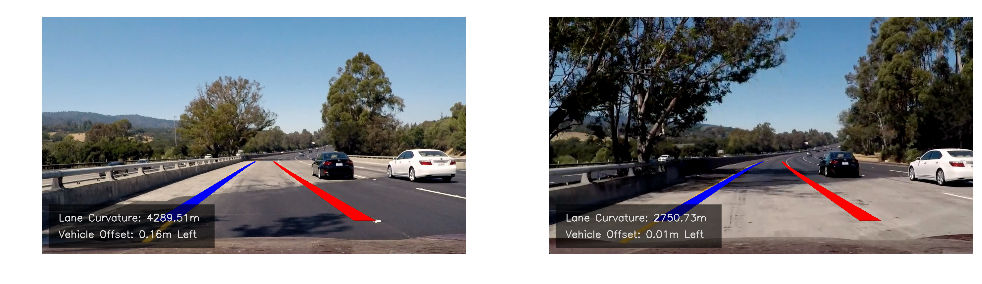

In [24]:
final_tests = [undistorted_examples[0], undistorted_examples[2]]
final_tests_out = []
for test in final_tests:
    img = process_image(test)
    final_tests_out.append(img)

plot(final_tests_out, 1, 2, 12., 4.)

** Process Sample:: *Project Video* **

In [25]:
easy_output = 'project_proc.mp4'
clip_easy = VideoFileClip("project_video.mp4")
easy_clip = clip_easy.fl_image(process_image)
%time easy_clip.write_videofile(easy_output, audio=False)

[MoviePy] >>>> Building video project_proc.mp4
[MoviePy] Writing video project_proc.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:03<00:00,  3.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_proc.mp4 

Wall time: 6min 4s


In [26]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(easy_output))

**Process Sample:: * Challenge Video* **

In [27]:
medium_output = 'challenge_proc.mp4'
clip_challenge = VideoFileClip("challenge_video.mp4")
medium_clip = clip_challenge.fl_image(process_image)
%time medium_clip.write_videofile(medium_output, audio=False)

[MoviePy] >>>> Building video challenge_proc.mp4
[MoviePy] Writing video challenge_proc.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [02:19<00:00,  3.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_proc.mp4 

Wall time: 2min 20s


In [ ]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(medium_output))

** Process Sample:: *Hard Challenge* **

In [ ]:
hard_output = 'harder_challenge_proc.mp4'
clip_hard = VideoFileClip("harder_challenge_video.mp4")
hard_clip = clip_hard.fl_image(process_image)
%time hard_clip.write_videofile(hard_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_proc.mp4
[MoviePy] Writing video harder_challenge_proc.mp4


 19%|███████████████▎                                                               | 232/1200 [01:07<04:49,  3.35it/s]

In [ ]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(hard_output))

## Reflection
The pipeline initially worked quite well, with little failures in the test images.  While it does correctly identify the lanes in the project video, it fails catastrophically in the challenge videos due to extreme variations in lighting.  In the pixel detection code (see find_window_centroids) it is using region prediction as well as moving averages to make sure lanes are symmetric and to enhance detection.  This prediction method was required to avoid deviations from detecting the lane during breaks in the lane lines.

To make this pipeline more robust, modifications should be made to include colour detections in the initial masking as well as using principal components analysis to normalise lane pixel regions.  This would help with failures in the window centroid finding function, which deviates due to lane region cross-over.

An additional process to keep the lane detections more robust would be using a weighted moving average dependent upon variations in lane pixel positions.  This would penalise large changes in pixel positions across frames which is obvious in the hard challenge video.

In conclusion, it would be interesting to see a convolutional network with recurrent connections, trained to detect lanes and compare the results...